<a href="https://colab.research.google.com/github/Abhinaba35/Demand-Forecasting-Using-Time-Series-Analysis/blob/main/TimeSeries_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/Retail_Dataset2.csv")

# Convert date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Product_id,Product_Code,Warehouse,Product_Category,Order_Demand,Open,Promo,StateHoliday,SchoolHoliday,Petrol_price
Date,,,,,,,,,,
2016-01-03,786725,Product_0033,Whse_S,Category_005,16000,1,0,0,0,91
2016-01-03,786743,Product_1825,Whse_S,Category_006,50000,1,0,0,0,85
2016-01-03,786967,Product_0551,Whse_S,Category_030,3000,1,0,0,0,85
2016-01-03,786856,Product_0556,Whse_S,Category_030,1000,1,0,0,0,93
2016-01-03,899538,Product_1844,Whse_A,Category_018,7,1,0,0,0,95


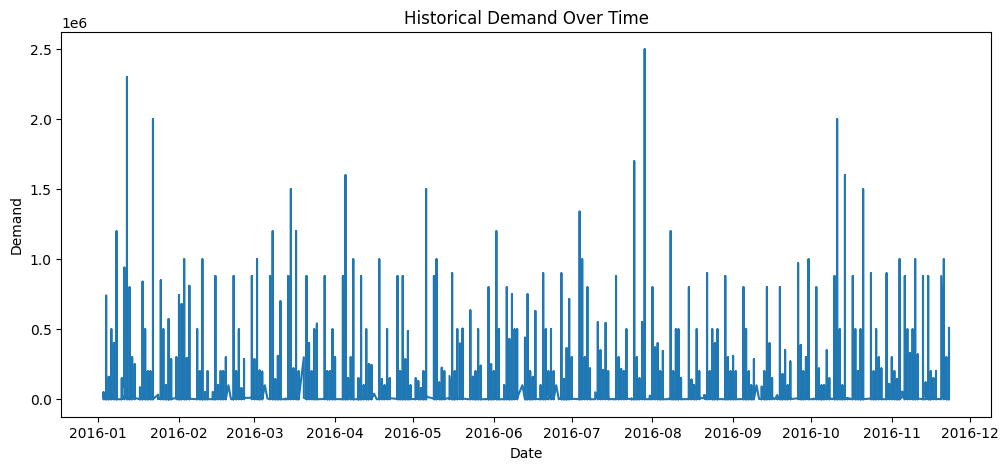

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df['Order_Demand'])
plt.title("Historical Demand Over Time")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()

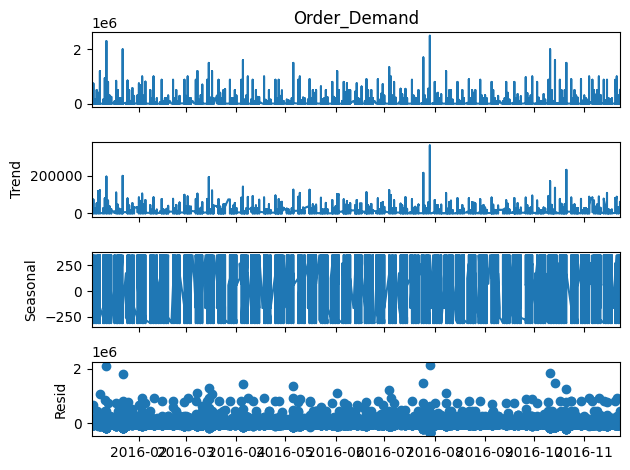

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df['Order_Demand'], model='additive', period=12)
decomposition.plot()
plt.show()

In [ ]:
# Aggregate Order_Demand by day to create a regular time series
daily_demand = df.groupby(df.index)['Order_Demand'].sum()

# Split the aggregated data into training and testing sets
train_size = int(len(daily_demand) * 0.8)
train = daily_demand.iloc[:train_size]
test = daily_demand.iloc[train_size:]

In [ ]:
arima_model = ARIMA(train, order=(1,1,1))
arima_fit = arima_model.fit()

arima_forecast = arima_fit.forecast(steps=len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

In [ ]:
hw_model = ExponentialSmoothing(
    train,
    trend='add',
    seasonal='add',
    seasonal_periods=12
)

hw_fit = hw_model.fit()
hw_forecast = hw_fit.forecast(len(test))

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
def evaluate_model(actual, predicted):
    # Ensure both are numpy arrays for element-wise operations
    actual_values = actual.values
    predicted_values = predicted.values

    mae = mean_absolute_error(actual_values, predicted_values)
    rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

    # Calculate MAPE, handling potential division by zero
    # Only include non-zero actual values in MAPE calculation
    non_zero_actual_indices = actual_values != 0
    if np.any(non_zero_actual_indices):
        mape = np.mean(np.abs((actual_values[non_zero_actual_indices] - predicted_values[non_zero_actual_indices]) / actual_values[non_zero_actual_indices])) * 100
    else:
        mape = np.nan # If all actual values are zero, MAPE is undefined

    return mae, rmse, mape

arima_metrics = evaluate_model(test, arima_forecast)
hw_metrics = evaluate_model(test, hw_forecast)

metrics_df = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [arima_metrics[0], hw_metrics[0]],
    'RMSE': [arima_metrics[1], hw_metrics[1]],
    'MAPE': [arima_metrics[2], hw_metrics[2]]
})

metrics_df

,Model,MAE,RMSE,MAPE
0,ARIMA,1.528905e+06,1.850045e+06,107627.571133
1,Exponential Smoothing,1.686849e+06,1.966345e+06,100813.227334


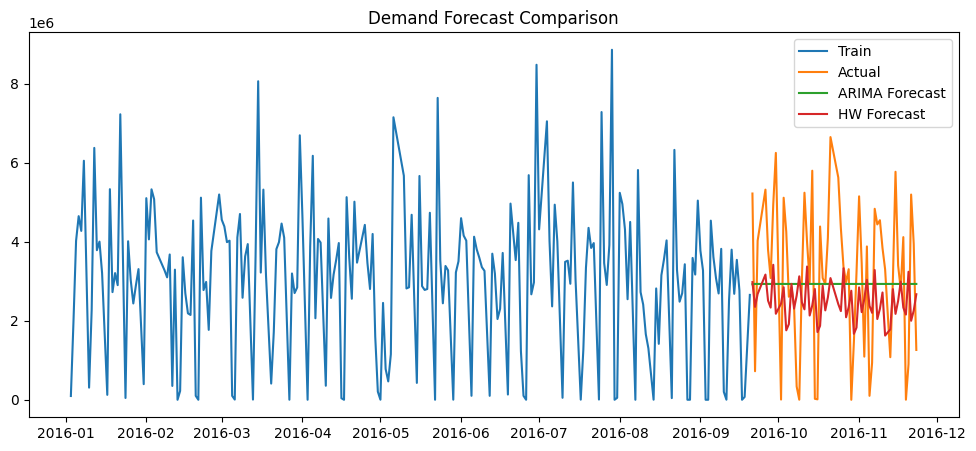

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, hw_forecast, label='HW Forecast')
plt.legend()
plt.title("Demand Forecast Comparison")
plt.show()

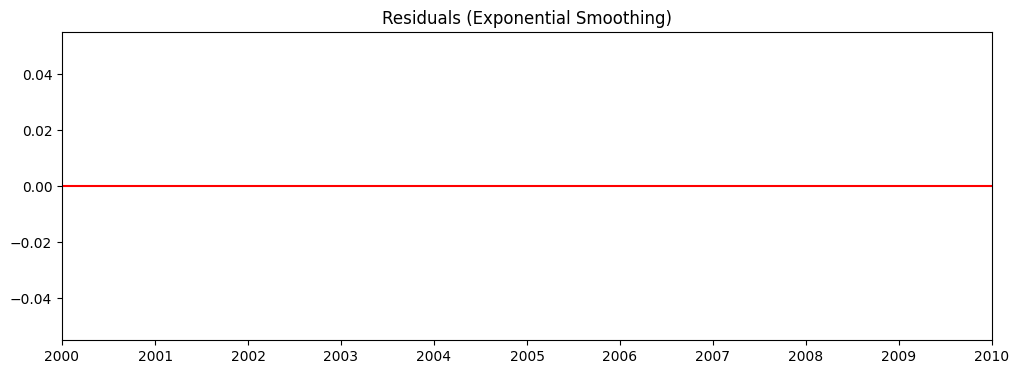

In [ ]:
residuals = test - hw_forecast

plt.figure(figsize=(12,4))
plt.plot(residuals)
plt.title("Residuals (Exponential Smoothing)")
plt.axhline(0, color='red')
plt.show()

In [ ]:
best_model = metrics_df.sort_values(by='RMSE').iloc[0]
best_model


,0
Model,ARIMA
MAE,1528905.311147
RMSE,1850044.613813
MAPE,107627.571133


In [ ]:
final_model = ExponentialSmoothing(
    df['Order_Demand'],
    trend='add',
    seasonal='add',
    seasonal_periods=12
).fit()

future_forecast = final_model.forecast(12)
future_forecast


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/holtwinters/model.py:85: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,0
169211,4944.510046
169212,4788.152207
169213,6137.285530
169214,4723.520262
169215,4918.099547
169216,5717.642756
169217,5365.904173
169218,4163.638370
169219,4595.494475
169220,8830.332607
